In [5]:
import polars as pl 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from typing import List
import numpy as np
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

True

# **FUNCIONES**

In [3]:
# Función para mostrar las frecuencias absolutas y relativas de un campo
def frecuencia_categoria(df,columna,orden):
    resultado = df.groupby([columna]).agg(CANTIDAD=(columna, 'count')).reset_index()
    total = resultado['CANTIDAD'].sum()
    resultado['% TOTAL'] = (resultado['CANTIDAD'] / total) * 100
    if orden == 0:
        resultado = resultado.sort_values('% TOTAL', ascending=False)
        return resultado
    elif orden == 1:
        resultado = resultado.sort_values(columna, ascending=True)
        return resultado
    else:
        return print('En orden solo puede escoger los valores 0,1')
        


# Función para graficar los campos categóricos
# Recomendaciones ncol=2, color='rocket',grafico=barplot
def plot_categoria(df,lista_campos,ncol,color,ancho,largo):
    # Calcular el número de filas y columnas para organizar los subgráficos
    num_filas = (len(lista_campos) + 1) // ncol
    num_columnas = ncol if len(lista_campos) > 1 else 1

    # Crear la figura y los subgráficos
    fig, axs = plt.subplots(num_filas, num_columnas, figsize=(ancho, largo))

    # Ajustar los espacios entre los subgráficos
    plt.subplots_adjust(hspace=0.2)

    # Iterar sobre los encabezados y crear un gráfico para cada columna del DataFrame
    for i, encabezado in enumerate(lista_campos):
        fila = i // ncol
        columna = i % ncol if num_columnas > 1 else 0
        ax = axs[fila, columna] if num_filas > 1 else axs[columna]
        counts = df[encabezado].value_counts()  # Obtener conteo de valores
        sns.barplot(x=counts.values, y=counts.index, palette=color, ax=ax)
        ax.set_title(f"CATEGORÍA {encabezado}")
        ax.set_ylabel("")  # Eliminar título del eje y

    return plt.show()

def var_nan_flag(df, columna, null="None"):
    new_col_name = columna + '_flag'
    if null=="None":

        df = (
            df
            .with_columns(
                pl.when(pl.col(columna).is_null())
                .then(pl.lit(1))
                .otherwise(pl.lit(0))
                .alias(new_col_name)
            )
        )
    
    elif null!="None":
        df = (
            df
            .with_columns(
                pl.when(pl.col(columna)==null)
                .then(pl.lit(1))
                .otherwise(pl.lit(0))
                .alias(new_col_name)
            )
        )

    return df

def missing_values_table(df):

    mis_val = df.select(pl.all().is_null().sum())
    mis_val_percent = 100 * mis_val / len(df)

    mis_val = mis_val.row(0)
    mis_val_percent = mis_val_percent.row(0)
    mis_val_columnas = df.columns

    mis_val_table = (

        pl.DataFrame(
            {
                'columnas':mis_val_columnas,
                'num_missings':mis_val,
                '% missings':mis_val_percent
            }
        )
        .filter(pl.col('num_missings')!=0)
        .sort('num_missings', descending=True)
    )
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table.shape[0]) +
          " columns that have missing values.")

    return mis_val_table, mis_val_table.get_column('columnas').to_list()

def reemplazar_por_mediana(x,limite_superior,limite_inferior,mediana):
    if (x>limite_superior)|(x<limite_inferior):
        return mediana
    else:
        return x
    
def porcentaje_outlier(df, column):
    rango_intercuartil = df.get_column(column).quantile(0.75) - df.get_column(column).quantile(0.25)
    limite_superior = df.get_column(column).quantile(0.75) + 1.5*rango_intercuartil
    limite_inferior = df.get_column(column).quantile(0.25) - 1.5*rango_intercuartil
    

    outliers_count = df.shape[0] - df.filter(pl.col(column).is_between(limite_inferior,limite_superior)).shape[0]

    return limite_superior,limite_inferior, np.round(outliers_count*100/df.shape[0],2)
    
def tratar_outlier(df, column, min=0.0001,max=0.95):

    limite_superior,limite_inferior, porcentaje = porcentaje_outlier(df, column)
        
    if (porcentaje>=5):

        percentil_95 = df.get_column(column).quantile(max)
        percentil_2 = df.get_column(column).quantile(min)
        df = df.with_columns(pl.col(column).map_elements(lambda x: percentil_95 if x > percentil_95 else x))
        df = df.with_columns(pl.col(column).map_elements(lambda x: percentil_2 if x < percentil_2 else x))
        return df
    else:
        return df
    
def reemplazar_negativo(df, columna):

    return (
        df
        .with_columns(pl.when(pl.col(columna)<0).then(pl.lit(0)).otherwise(pl.col(columna)).alias(columna))
    )

# **RUTA Y CARGAR DATA**

In [6]:
GENERAL_DIR = os.getenv('DIRECTORIO')
RUTA_CAMPAIGNS = GENERAL_DIR + r"data\raw\archivo 9230_0104_EY_Proyecto_v2.TXT"

In [7]:
df_campaña = (
    pl.scan_csv(
        RUTA_CAMPAIGNS, 
        encoding='utf8-lossy',
        dtypes = {
            'PRODUCTOS_TC':pl.String,
            
            'BIRTHDATE':pl.Date,
            'HIRE_DT':pl.Date,


            'AA_VLR_ING_BRU_MES':pl.Float64,
            'BB_SCORE_COMPORTA':pl.Float64,
            'AA_VLR_PASIVOS':pl.Float64,
            'SALDO_ACTIVO':pl.Float64,
            'SALDO_AH_NOMINA':pl.Float64,
            'SALDO_AH_NO_NOMINA':pl.Float64,
            'SALDO_TC':pl.Float64,
            'SALDO_CDT':pl.Float64,
            'SALDO_DEUDOR':pl.Float64,
            'SALDO_LIBRE_DEST':pl.Float64,
            'SALDO_HIPOTECARIO':pl.Float64,
            'SALDO_SUT_PASIV':pl.Float64,
            'SALDO_CUENTA':pl.Float64,
            'CUPO_CTA':pl.Float64,
            'DISPONIBLE_CTA':pl.Float64,
            'INTERES_CTE':pl.Float64,
            'SALDO_PASIVOS':pl.Float64,
            'VALOR_DEB_NOMINA':pl.Float64,
            'VALOR_CRED_NOMINA':pl.Float64,
            'VALOR_DEB_NO_NOM':pl.Float64,
            'VALOR_CRED_NO_NOM':pl.Float64,
            'RENTABILIDAD':pl.Float64,
            'MARGEN_NETO':pl.Float64,
            'SALDO_TC_MES_ANT':pl.Float64,
            'SALDO_LIBRANZAS':pl.Float64,


            'CL_NEW':pl.Int64,
            'CANT_TC':pl.Int64,
            'ATRASO_MORA':pl.Int64,
            'CANT_APERTURAS':pl.Int64,
            'CANT_TC_MES_ANT':pl.Int64,
        }
    )
    .lazy()
)

In [8]:
df_campaña = df_campaña.collect()

# **REVISAR NULOS POR COLUMNA**

In [77]:
LISTA_COLUMNAS_CON_MISSINGS = missing_values_table(df_campaña)[1]

Your selected dataframe has 51 columns.
There are 32 columns that have missing values.


In [78]:
missing_values_table(df_campaña)[0].to_pandas()

Your selected dataframe has 51 columns.
There are 32 columns that have missing values.


,columnas,num_missings,% missings
0,CANT_APERTURAS,2336736,98.811632
1,ATRASO_MORA,2298210,97.182514
2,RENTABILIDAD,2092418,88.480357
3,MARGEN_NETO,2092418,88.480357
4,SALDO_TC_MES_ANT,1987987,84.064370
5,CANT_TC_MES_ANT,1987987,84.064370
6,VALOR_DEB_NO_NOM,1136885,48.074520
7,VALOR_DEB_NOMINA,1136796,48.070757
8,VALOR_CRED_NOMINA,1136779,48.070038
9,VALOR_CRED_NO_NOM,1136779,48.070038


In [87]:
missing_values_table(df_campaña.select(pl.col(pl.Float64)))[0].to_pandas()

Your selected dataframe has 25 columns.
There are 25 columns that have missing values.


,columnas,num_missings,% missings
0,RENTABILIDAD,2092418,88.480357
1,MARGEN_NETO,2092418,88.480357
2,SALDO_TC_MES_ANT,1987987,84.064370
3,VALOR_DEB_NO_NOM,1136885,48.074520
4,VALOR_DEB_NOMINA,1136796,48.070757
5,VALOR_CRED_NOMINA,1136779,48.070038
6,VALOR_CRED_NO_NOM,1136779,48.070038
7,SALDO_PASIVOS,74095,3.133194
8,SALDO_ACTIVO,74095,3.133194
9,SALDO_AH_NOMINA,74095,3.133194


# **VALORES DE COLUMNAS STRING**

In [41]:
columnas_strings = df_campaña.select(pl.col(pl.String)).drop(['DEFINIT','ID']).columns

In [43]:
for columna in columnas_strings:
    print('_____________________________________________________')
    print(' '+columna)
    print('\n')
    print(frecuencia_categoria(df_campaña.to_pandas(),columna,0))
    print('_____________________________________________________')
    print('\n')


_____________________________________________________
 CANAL_VENTA


   CANAL_VENTA  CANTIDAD    % TOTAL
2      DIGITAL   1233778  52.171755
4      OFICINA    558176  23.603129
5     REACTIVO    249688  10.558351
3          FMV    197023   8.331349
1  CALL CENTER    125319   5.299261
0                    855   0.036155
_____________________________________________________


_____________________________________________________
 SEX


  SEX  CANTIDAD    % TOTAL
3   M   1245800  52.680119
2   F   1074259  45.426306
0         44764   1.892898
1   B        11   0.000465
4   T         5   0.000211
_____________________________________________________


_____________________________________________________
 MAR_STATUS


     MAR_STATUS  CANTIDAD    % TOTAL
6     SOLTERO/A   1527759  64.603087
2      CASADO/A    363677  15.378510
7   UNION LIBRE    212613   8.990591
0                  175564   7.423930
5    SEPARADO/A     37758   1.596641
4          OTRO     21391   0.904544
8       VIUDO/A  

# **EEEEEEEEEEEEE**

In [25]:
RUTA_BURO = r"C:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG\data\interim\buro_colombia_2.parquet"

In [26]:
buro = pl.scan_parquet(RUTA_BURO).unique('DEFINIT').collect()

In [27]:
buro.unique('DEFINIT').shape[0]

2107868

In [36]:
df_campaña.shape

(2364839, 51)

In [17]:
df_campaña.unique('DEFINIT').shape[0]

1278437

In [37]:
(
    df_campaña
    #.unique('DEFINIT')
    .join(
        buro, on='DEFINIT',  how='left'
    )
    .filter(pl.col('CORTE').is_null())
    .filter(pl.col('CANT_TC')==0)
    #.unique('CANT_TC')
)

FECHA_BASE,DEFINIT,CANAL_VENTA,BIRTHDATE,SEX,MAR_STATUS,NIVEL_EDUCATIVO,AA_VLR_ING_BRU_MES,BB_SCORE_COMPORTA,HIRE_DT,AA_VLR_PASIVOS,ESTADO_CAMP,TIPO_APROBACION,CAMPANAS_NUM,ESTADO_CL,CL_NEW,ID,SALDO_PASIVOS,SALDO_ACTIVO,SALDO_AH_NOMINA,SALDO_AH_NO_NOMINA,SALDO_TC,CANT_TC,SALDO_CDT,SALDO_DEUDOR,SALDO_LIBRE_DEST,SALDO_LIBRANZAS,SALDO_HIPOTECARIO,SALDO_SUT_PASIV,SALDO_CUENTA,CUPO_CTA,DISPONIBLE_CTA,INTERES_CTE,PRODUCTOS_TC,V_EN_CAMPANIA_MENSUAL,NM_SEG_CL,AGR_SEG,EMPLEADO,BIN_INICIO,VALOR_DEB_NOMINA,VALOR_CRED_NOMINA,VALOR_DEB_NO_NOM,VALOR_CRED_NO_NOM,RENTABILIDAD,MARGEN_NETO,ATRASO_MORA,CANT_APERTURAS,CIUDAD,DEPARTAMENTO,SALDO_TC_MES_ANT,CANT_TC_MES_ANT,score_advance,DESC_ESTADO_3,TIPO_CUENTA_3,NOMBRE_SUSC_3,FECHA_VENCIMIENTO_3,FECHA_APERTURA_3,CUOTAS_CANCELADAS_8,TOTAL_CUOTAS_8,VALOR_INICIAL,SALDO_ACTUAL,CUOTA,PERIODICIDAD_PAGO,TIPO_OBLIGACION,CORTE
i64,str,str,date,str,str,str,f64,f64,date,f64,str,str,i64,str,i64,str,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,str,str,str,str,f64,f64,f64,f64,f64,f64,i64,i64,str,str,f64,i64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str
202403,"""C1010059516""","""DIGITAL""",1999-08-24,"""M""","""SOLTERO/A""","""SECUNDARIO""",1.2e6,-999.0,2018-09-07,0.0,"""Campa�a Cerrad…","""OFERTA COMERCI…",1,"""Activo""",0,"""C1010059516""",1083.0,0.0,0.0,1083.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""""",1,"""Personas Renta…","""Total Segmento…","""""","""""",null,null,null,null,null,null,null,null,"""BOGOTA DISTRI…","""BOGOTA D. C. …",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
202309,"""C1010140678""","""FMV""",2000-07-31,"""F""","""SOLTERO/A""","""SECUNDARIO""",300000.0,-999.0,2019-08-12,100000.0,"""Campa�a Cerrad…","""FIRME FIRME""",1,"""Activo""",0,"""C1010140678""",5.868294e6,0.0,0.0,5.868294e6,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""""",1,"""Personas Renta…","""Total Segmento…","""""","""""",0.0,0.0,19500.0,500471.0,null,null,null,null,"""""","""""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
202402,"""C1010141287""","""DIGITAL""",2003-12-25,"""F""","""SOLTERO/A""","""SECUNDARIO""",1.16e6,-999.0,2023-04-25,0.0,"""Campa�a Cerrad…","""OFERTA COMERCI…",1,"""Activo""",0,"""C1010141287""",1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""""",1,"""Personas Renta…","""Total Segmento…","""""","""""",null,null,null,null,null,null,null,null,"""""","""""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
202312,"""C1010172884""","""CALL CENTER""",1987-09-03,"""M""","""SOLTERO/A""","""SECUNDARIO""",1.638124e6,-999.0,2008-07-29,50000.0,"""Campa�a Cerrad…","""FIRME FIRME""",1,"""Activo""",0,"""C1010172884""",1.078934e6,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""""",1,"""Personas Bajo""","""Total Segmento…","""""","""""",3.3e6,2.624913e6,0.0,0.0,null,null,null,null,"""BOGOTA DISTRI…","""BOGOTA D. C. …",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
202401,"""C1010196189""","""DIGITAL""",1991-01-31,"""F""","""SOLTERO/A""","""T�CNICO O TECN…",828000.0,-999.0,2015-11-12,700000.0,"""Campa�a Cerrad…","""OFERTA COMERCI…",1,"""Inactivo""",0,"""C1010196189""",1068.0,0.0,0.0,509.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""""",1,"""Personas Renta…","""Total Segmento…","""""","""""",null,null,null,null,null,null,null,null,"""BOGOTA DISTRI…","""BOGOTA D. C. …",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
202403,"""C1003241519""","""DIGITAL""",1996-09-06,"""M""","""SOLTERO/A""","""T�CNICO O TECN…",1.588855e6,-999.0,2016-10-07,0.0,"""Campa�a Cerrad…","""OFERTA COMERCI…",1,"""Activo""",0,"""C1003241519""",28441.0,0.0,0.0,28441.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""""",1,"""Personas Bajo""","""Total Segmento…","""""","""""",0.0,0.0

<Axes: ylabel='BB_SCORE_COMPORTA'>

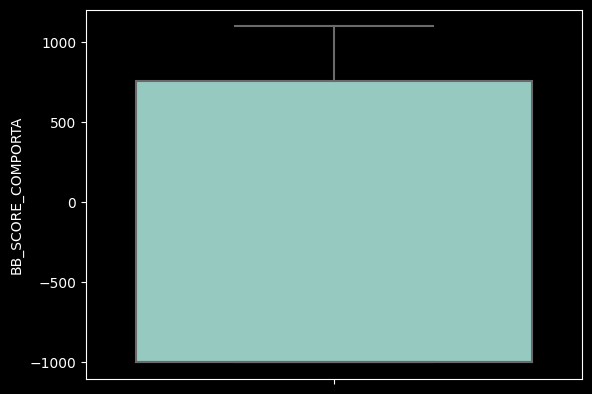

In [21]:
sns.boxplot(df_campaña.to_pandas(), y = 'BB_SCORE_COMPORTA')